## Emotions labelling

In [1]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# set the option to display all columns
pd.set_option('display.max_columns', None)

## LEIA 

The model LEIA/LEIA-base can predict Sadness, Anger, Fear, Affection and Happinnes labels.

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
# Load the LEIA model
model_name = "LEIA/LEIA-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

emotions = {0: 'Sadness', 1:'Happiness', 2:'Fear', 3:'Affection', 4:'Anger'}

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


### GPT4

In [5]:
gpt4 = pd.read_csv('gpt4_full_merged.csv')
# filter outliers
gpt4 = gpt4[(gpt4['gpt4_simple'].str.len() >246) & (gpt4['gpt4_simple'].str.len() < 322)]

In [7]:
gpt4.head(1)

,id,author_id,in_reply_to_user_id,quoted_user_id,retweeted_user_id,text,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,entities.hashtags,entities.mentions,author.username,author.name,author.description,author.location,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.tweet_count,url,link_text,party,name,Occupation(s),Education,Residence[5],sentiment,age,gender,gpt4_simple,gpt4_simple_sentiment,gpt4_no_polit,gpt4_no_polit_label,gpt4_name,gpt4_name_label,gpt4_using,gpt4_using_label,gpt4_arg,gpt4_arg_label,gpt4_edu,gpt4_edu_label,gpt4_age,gpt4_age_label,gpt4_gender,gpt4_gender_label,text_text_emotion,text_emotion_score,gpt4_simple_text_emotion,gpt4_simple_emotion_score,gpt4_no_polit_text_emotion,gpt4_no_polit_emotion_score,gpt4_name_text_emotion,gpt4_name_emotion_score,gpt4_using_text_emotion,gpt4_using_emotion_score,gpt4_arg_text_emotion,gpt4_arg_emotion_score,gpt4_edu_text_emotion,gpt4_edu_emotion_score,gpt4_age_text_emotion,gpt4_age_emotion_score,gpt4_gender_text_emotion,gpt4_gender_emotion_score,gpt4_simple_bert_sentiment,gpt4_no_polit_bert_class,gpt4_using_bert_class,gpt4_arg_bert_class,gpt4_edu_bert_class,gpt4_gender_bert_class,gpt4_age_bert_class
0,1174499599181959168,262192574,NaN,NaN,NaN,We should never forget the sacrifices made by ...,22,0,0,2,NaN,NaN,cindyhydesmith,Cindy Hyde-Smith,Lifelong conservative proudly fighting for the...,"Mississippi, USA",20222,199,2232,https://www.wdam.com/2019/09/18/senator-cindy-...,MISSISSIPPI (WLOX) - U.S. Senator Cindy Hyde-S...,Republican,Cindy Hyde-Smith,Lobbyist Farmer,Copiah-Lincoln Community College (AA) Universi...,Brookhaven,positive,65,female,Honoring those who made the ultimate sacrifice...,positive,Honoring our Gold Star Families is crucial. Th...,positive,We must,neutral,Honoring our Gold Star Families is a deeply co...,positive,Honoring our Gold Star Families is crucial. Th...,positive,Honoring Gold Star Families is a crucial remin...,positive,Honoring the bravery and sacrifice of our Gold...,positive,Honoring our fallen heroes means also supporti...,positive,sadness,0.531065,fear,0.402512,sadness,0.625089,neutral,0.38993,joy,0.694836,joy,0.643722,sadness,0.750784,joy,0.465563,fear,0.539729,positive,positive,positive,positive,positive,positive,positive


In [8]:
# filter non neutral tweets
gpt4 = gpt4[gpt4['sentiment']!='neutral']

In [9]:
# Initialize tqdm
tqdm.pandas(desc="Processing sentences")

# Apply the function with progress_apply
gpt4['leia_true'] = gpt4['text'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 7973/7973 [05:41<00:00, 23.38it/s]


In [10]:
# Apply the function with progress_apply
gpt4['gpt4_simple_leia'] = gpt4['gpt4_simple'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 7973/7973 [05:53<00:00, 22.57it/s]


In [11]:
true_values = gpt4['leia_true']
predicted_values = gpt4['gpt4_simple_leia']

# Calculate accuracy
accuracy_gpt4 = accuracy_score(true_values, predicted_values)

# Calculate precision, recall, and F1-score for each class
precision_gpt4 = precision_score(true_values, predicted_values, average=None, labels=['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'])
recall_gpt4 = recall_score(true_values, predicted_values, average=None, labels=['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'])
f1_gpt4 = f1_score(true_values, predicted_values, average=None, labels=['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'])

# Calculate overall precision, recall, and F1-score
precision_macro_gpt4 = precision_score(true_values, predicted_values, average='macro')
recall_macro_gpt4 = recall_score(true_values, predicted_values, average='macro')
f1_macro_gpt4 = f1_score(true_values, predicted_values, average='macro')

# Print the results
print("Accuracy:", accuracy_gpt4)
print("Precision:", precision_gpt4)
print("Recall ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'] :", recall_gpt4)
print("F1-score:", f1_gpt4)
print("Overall Precision:", precision_macro_gpt4)
print("Overall Recall:", recall_macro_gpt4)
print("Overall F1-score:", f1_macro_gpt4)

Accuracy: 0.5878590242066976
Precision: [0.48101266 0.51141227 0.38105727 0.48944193 0.73508883]
Recall ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'] : [0.456      0.61308251 0.19438202 0.56979807 0.69061103]
F1-score: [0.46817248 0.55765118 0.25744048 0.52657201 0.71215614]
Overall Precision: 0.5196025916488656
Overall Recall: 0.5047747266327615
Overall F1-score: 0.50439845696038


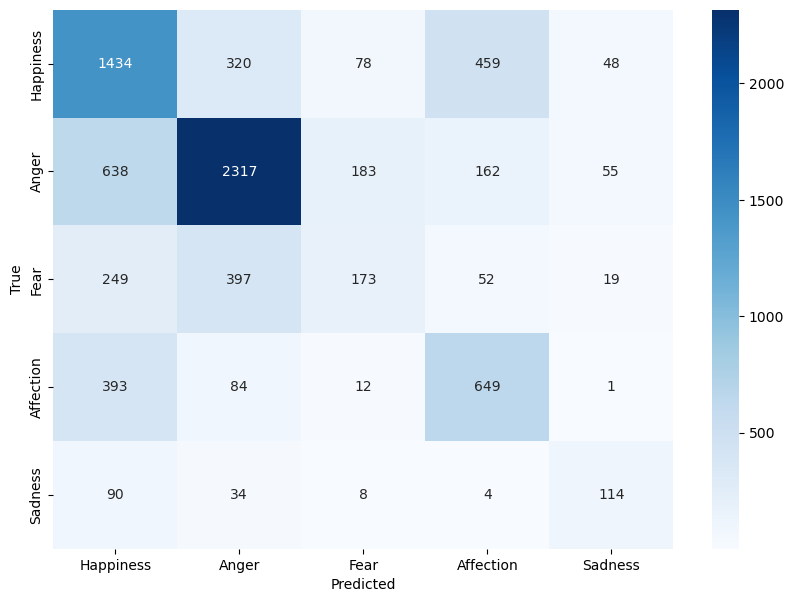

In [12]:
cm = confusion_matrix(gpt4['leia_true'], gpt4['gpt4_simple_leia'], labels=gpt4['leia_true'].unique())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gpt4['leia_true'].unique(), yticklabels=gpt4['leia_true'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.title('Confusion Matrix')
plt.show()

In [13]:
# Data
emotions = ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']
recall = [46.5, 61.9, 19.3, 56.5, 68.9]
precision = [49.8, 51.3, 38.0, 49.3, 73.3]
f1_score = [48.1, 56.1, 25.6, 52.6, 71.1]

# Create DataFrame
table1 = pd.DataFrame({
    'Emotion': emotions,
    'Recall (%)': recall,
    'Precision (%)': precision,
    'F1-score (%)': f1_score
})


table1

,Emotion,Recall (%),Precision (%),F1-score (%)
0,Sadness,46.5,49.8,48.1
1,Happiness,61.9,51.3,56.1
2,Fear,19.3,38.0,25.6
3,Affection,56.5,49.3,52.6
4,Anger,68.9,73.3,71.1


In [14]:
gpt4['leia_true'].value_counts()

leia_true
Anger        3355
Happiness    2339
Affection    1139
Fear          890
Sadness       250
Name: count, dtype: int64

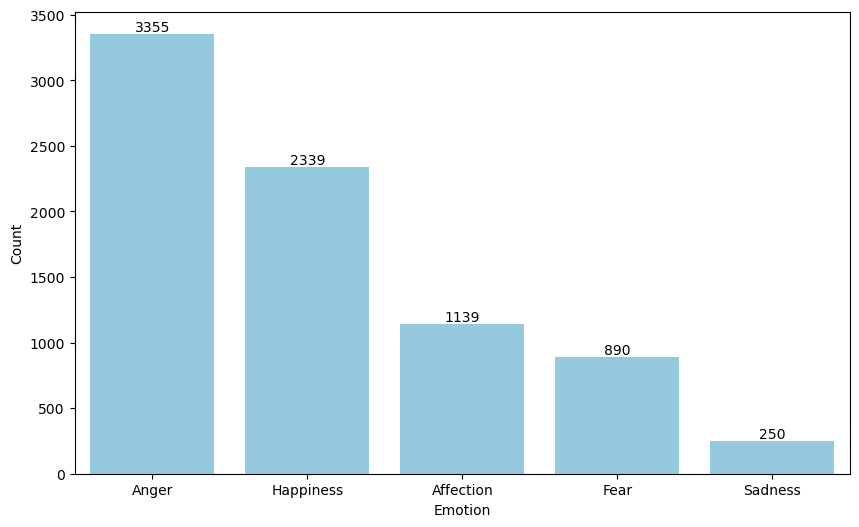

In [15]:

# Count the frequency of each label
label_counts_gpt4 = gpt4['leia_true'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts_gpt4.index, y=label_counts_gpt4.values, color='skyblue')

# Add count labels on top of each bar
for i, count in enumerate(label_counts_gpt4.values):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Customize the plot
plt.xlabel('Emotion')
plt.ylabel('Count')
#lt.title('Distribution of Emotion Labels for Original Tweets')
plt.show()


### GPT3 

In [16]:
gpt3 = pd.read_csv('gpt3_full_merged.csv')
gpt3 = gpt3[(gpt3['gpt3_simple'].str.len() > 178) & (gpt3['gpt3_simple'].str.len() < 342)]
gpt3.head(2)

,id,author_id,in_reply_to_user_id,quoted_user_id,retweeted_user_id,text,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,entities.hashtags,entities.mentions,author.username,author.name,author.description,author.location,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.tweet_count,url,link_text,party,name,Occupation(s),Education,Residence[5],sentiment,age,gender,gpt3_simple,gpt3_simple_sentiment,gpt3_no_polit,gpt3_no_polit_label,gpt3_name,gpt3_name_label,gpt3_using,gpt3_using_label,gpt3_arg,gpt3_arg_label,gpt3_edu,gpt3_edu_label,gpt3_age,gpt3_age_label,gpt3_gender,gpt3_gender_label,text_text_emotion,text_emotion_score,gpt3_simple_text_emotion,gpt3_simple_emotion_score,gpt3_no_polit_text_emotion,gpt3_no_polit_emotion_score,gpt3_name_text_emotion,gpt3_name_emotion_score,gpt3_using_text_emotion,gpt3_using_emotion_score,gpt3_arg_text_emotion,gpt3_arg_emotion_score,gpt3_edu_text_emotion,gpt3_edu_emotion_score,gpt3_age_text_emotion,gpt3_age_emotion_score,gpt3_gender_text_emotion,gpt3_gender_emotion_score,gpt3_simple_bert_sentiment
0,1174499599181959168,262192574,NaN,NaN,NaN,We should never forget the sacrifices made by ...,22,0,0,2,NaN,NaN,cindyhydesmith,Cindy Hyde-Smith,Lifelong conservative proudly fighting for the...,"Mississippi, USA",20222,199,2232,https://www.wdam.com/2019/09/18/senator-cindy-...,MISSISSIPPI (WLOX) - U.S. Senator Cindy Hyde-S...,Republican,Cindy Hyde-Smith,Lobbyist Farmer,Copiah-Lincoln Community College (AA) Universi...,Brookhaven,positive,65,female,Honoring the families of fallen service member...,positive,As a proud Republican and supporter of our mil...,positive,Honoring the sacrifices of our Gold Star Famil...,positive,Honoring our Gold Star Families is vital to re...,positive,As a proud representative of Mississippi and a...,positive,"Senator Hyde-Smith's proposal to establish ""Go...",positive,"As a proud Republican, I fully support U.S. Se...",positive,"As a proud Republican, I fully support Senator...",positive,sadness,0.531065,joy,0.722288,joy,0.764665,joy,0.619340,fear,0.436898,joy,0.412571,joy,0.869144,joy,0.553817,joy,0.716504,positive
1,1320738770543628288,15808765,NaN,NaN,NaN,It's no secret what Donald Trump and Senate Re...,1494,67,264,323,NaN,NaN,CoryBooker,Cory Booker,U.S. Senator from New Jersey. Most tweets (and...,"Newark, NJ",4835171,85102,67749,https://thehill.com/homenews/administration/52...,President Trump says in an interview with “60 ...,Democrat,Cory Booker,Lawyer,"Stanford University (BA, MA) Queen's College, ...",Newark,negative,55,male,"As a Democrat, I am appalled by Trump's plan t...",negative,"As a lawyer and a Democrat, I am appalled by T...",negative,President Trump's lack of a concrete health ca...,negative,"As a lawyer, I can confirm that the ACA provid...",negative,"As a Democrat, I am appalled by Trump's plan t...",positive,"As a Democrat, I am appalled by Trump's desire...",negative,"As a Democrat, I am deeply troubled by Trump's...",negative,"President Trump's interview with ""60 Minutes"" ...",negative,anger,0.914568,anger,0.564595,fear,0.764343,fear,0.990454,fear,0.987793,anger,0.535079,fear,0.709620,fear,0.967225,fear,0.951202,negative


In [18]:
# filter non neutral tweets
gpt3 = gpt3[gpt3['sentiment']!='neutral']

In [26]:
# Apply the function with progress_apply
gpt3['leia_true'] = gpt3['text'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 8323/8323 [06:18<00:00, 21.99it/s]


In [20]:
# Apply the function with progress_apply
emotions = {0: 'Sadness', 1:'Happiness', 2:'Fear', 3:'Affection', 4:'Anger'}
gpt3['gpt3_simple_leia'] = gpt3['gpt3_simple'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 8323/8323 [06:08<00:00, 22.57it/s]


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

true_values = gpt3['leia_true']
predicted_values = gpt3['gpt3_simple_leia']

accuracy_gpt3 = accuracy_score(true_values, predicted_values)

# Calculate precision, recall, and F1-score for each class
precision_gpt3 = precision_score(true_values, predicted_values, average=None, labels=['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'])
recall_gpt3 = recall_score(true_values, predicted_values, average=None, labels=['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'])
f1_gpt3 = f1_score(true_values, predicted_values, average=None, labels=['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger'])

# Calculate overall precision, recall, and F1-score
precision_macro_gpt3 = precision_score(true_values, predicted_values, average='macro')
recall_macro_gpt3 = recall_score(true_values, predicted_values, average='macro')
f1_macro_gpt3 = f1_score(true_values, predicted_values, average='macro')

# Print the results
print("Accuracy:", accuracy_gpt3)
print("Precision:", precision_gpt3)
print("Recall ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']:", recall_gpt3)
print("F1-score:", f1_gpt3)
print("Overall Precision:", precision_macro_gpt3)
print("Overall Recall:", recall_macro_gpt3)
print("Overall F1-score:", f1_macro_gpt3)

Accuracy: 0.5786375105130361
Precision: [0.53090909 0.51669421 0.35470085 0.47728911 0.74846626]
Recall ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']: [0.54275093 0.63640065 0.26977248 0.55630252 0.63012912]
F1-score: [0.53676471 0.57033388 0.30646154 0.51377571 0.68421873]
Overall Precision: 0.5256119062697268
Overall Recall: 0.5270711415405955
Overall F1-score: 0.5223109117737235


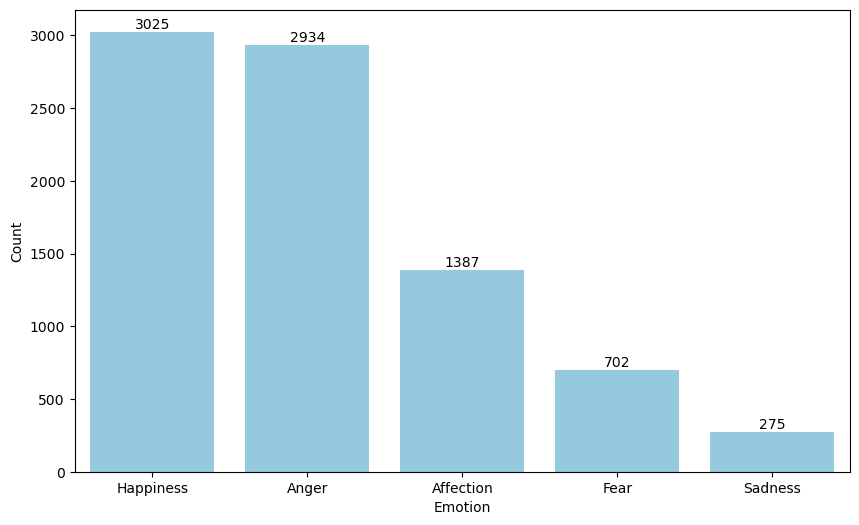

In [29]:
# Count the frequency of each label
label_counts_gpt3 = gpt3['gpt3_simple_leia'].value_counts()

# Count the frequency of each label
label_counts = gpt4['leia_true'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts_gpt3.index, y=label_counts_gpt3.values, color='skyblue')

# Add count labels on top of each bar
for i, count in enumerate(label_counts_gpt3.values):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Customize the plot
plt.xlabel('Emotion')
plt.ylabel('Count')
#lt.title('Distribution of Emotion Labels for GPT-3 Tweets')
plt.show()

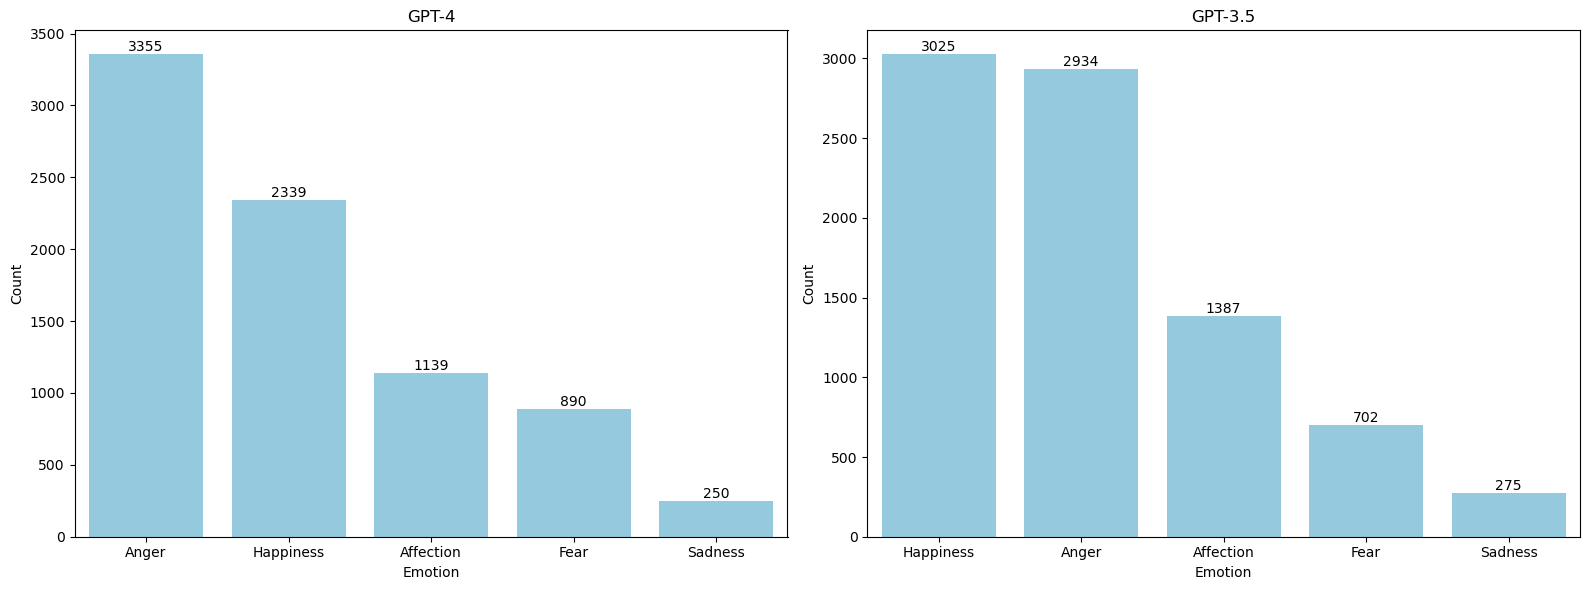

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution of GPT-4 emotion labels
label_counts_gpt4 = gpt4['leia_true'].value_counts()
ax1 = sns.barplot(x=label_counts_gpt4.index, y=label_counts_gpt4.values, color='skyblue', ax=axes[0])

# Add count labels on top of each bar for GPT-4 plot
for i, count in enumerate(label_counts_gpt4.values):
    ax1.text(i, count, str(count), ha='center', va='bottom')

# Customize the first plot
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Count')
ax1.set_title('GPT-4')

# Plot 2: Distribution of GPT-3 emotion labels
label_counts_gpt3 = gpt3['gpt3_simple_leia'].value_counts()
ax2 = sns.barplot(x=label_counts_gpt3.index, y=label_counts_gpt3.values, color='skyblue', ax=axes[1])

# Add count labels on top of each bar for GPT-3 plot
for i, count in enumerate(label_counts_gpt3.values):
    ax2.text(i, count, str(count), ha='center', va='bottom')

# Customize the second plot
ax2.set_xlabel('Emotion')
ax2.set_ylabel('Count')
ax2.set_title('GPT-3.5')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


In [31]:
# Data
emotions = ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']
recall = [53.8, 63.8, 26.9, 55.2, 63.1]
precision = [53.1, 51.5, 35.7, 47.8, 74.8]
f1_score = [53.5, 57.0, 30.7, 51.2, 68.5]

# Create DataFrame
table2 = pd.DataFrame({
    'Emotion': emotions,
    'Recall (%)': recall,
    'Precision (%)': precision,
    'F1-score (%)': f1_score
})

# Display the DataFrame
table2

,Emotion,Recall (%),Precision (%),F1-score (%)
0,Sadness,53.8,53.1,53.5
1,Happiness,63.8,51.5,57.0
2,Fear,26.9,35.7,30.7
3,Affection,55.2,47.8,51.2
4,Anger,63.1,74.8,68.5


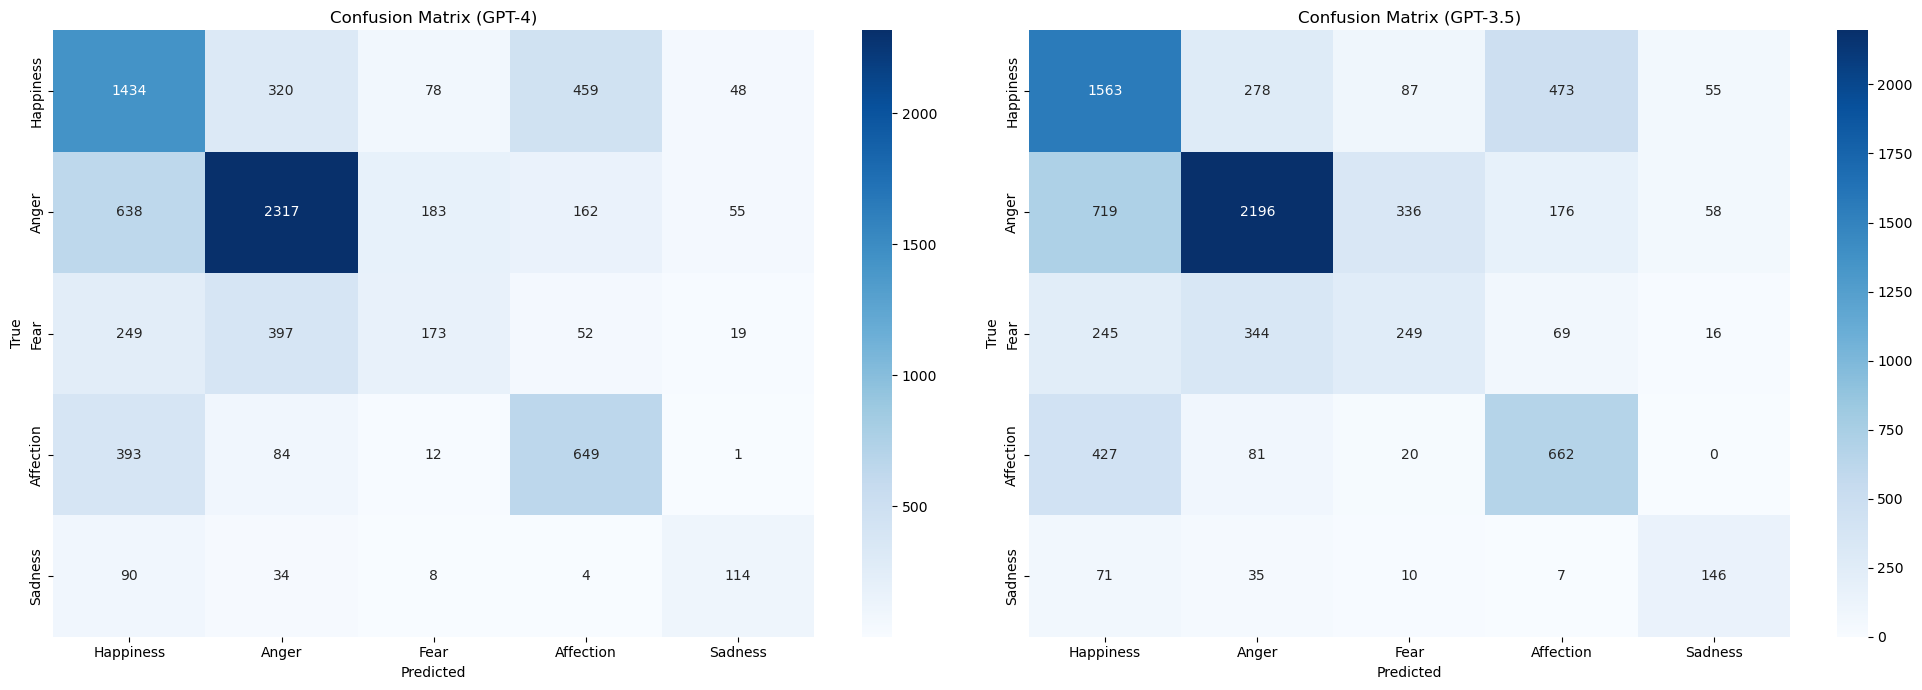

In [32]:
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Confusion Matrix for GPT-4
cm_gpt4 = confusion_matrix(gpt4['leia_true'], gpt4['gpt4_simple_leia'], labels=gpt4['leia_true'].unique())
sns.heatmap(cm_gpt4, annot=True, fmt='d', cmap='Blues', xticklabels=gpt4['leia_true'].unique(), yticklabels=gpt4['leia_true'].unique(), ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (GPT-4)')

# Plot 2: Confusion Matrix for GPT-3
cm_gpt3 = confusion_matrix(gpt3['leia_true'], gpt3['gpt3_simple_leia'], labels=gpt3['leia_true'].unique())
sns.heatmap(cm_gpt3, annot=True, fmt='d', cmap='Blues', xticklabels=gpt3['leia_true'].unique(), yticklabels=gpt3['leia_true'].unique(), ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (GPT-3.5)')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


### Llama

In [38]:
llama = pd.read_csv('llama/sample.csv')
llama = llama[(llama['llama_simple'].str.len() >33) & (llama['llama_simple'].str.len() < 535)]
llama = llama[llama['llama_simple'].notna()]

In [40]:
# filter non neutral tweets
llama = llama[llama['sentiment']!='neutral']

emotions = {0: 'Sadness', 1:'Happiness', 2:'Fear', 3:'Affection', 4:'Anger'}
llama['leia_true'] = llama['text'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 6869/6869 [04:54<00:00, 23.31it/s]


In [41]:
# Apply the function with progress_apply
llama['llama_simple_leia'] = llama['llama_simple'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 6869/6869 [05:54<00:00, 19.40it/s]


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure there are no naming conflicts
true_values = llama['leia_true'].astype('str')
predicted_values = llama['llama_simple_leia'].astype('str')

# Calculate accuracy
accuracy_llama = accuracy_score(true_values, predicted_values)

# Define labels
labels = ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']

# Calculate precision, recall, and F1-score for each class
precision_llama = precision_score(true_values, predicted_values, average=None, labels=labels)
recall_llama = recall_score(true_values, predicted_values, average=None, labels=labels)
f1_llama = f1_score(true_values, predicted_values, average=None, labels=labels)

# Calculate overall precision, recall, and F1-score
precision_macro_llama = precision_score(true_values, predicted_values, average='macro')
recall_macro_llama = recall_score(true_values, predicted_values, average='macro')
f1_macro_llama = f1_score(true_values, predicted_values, average='macro')

# Print the results
print("Accuracy:", accuracy_llama)
print("Precision:", precision_llama)
print("Recall:", recall_llama)
print("F1-score:", f1_llama)
print("Overall Precision:", precision_macro_llama)
print("Overall Recall:", recall_macro_llama)
print("Overall F1-score:", f1_macro_llama)


Accuracy: 0.5127383898675207
Precision: [0.32423208 0.51833873 0.23497268 0.39937107 0.65710081]
Recall: [0.43378995 0.46425121 0.22661397 0.50850851 0.63288448]
F1-score: [0.37109375 0.48980632 0.23071764 0.44738001 0.64476534]
Overall Precision: 0.42680307303691245
Overall Recall: 0.4532096230826238
Overall F1-score: 0.4367526122033749


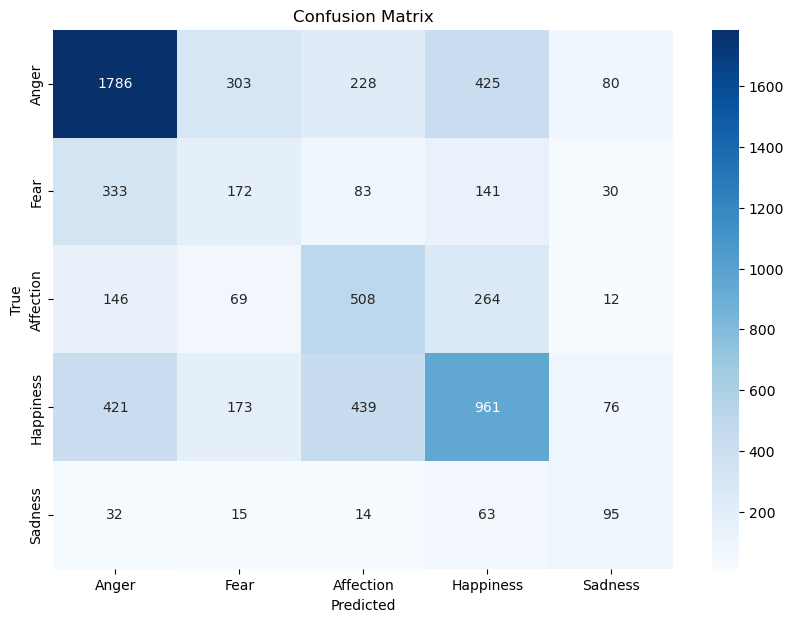

In [43]:
llama['leia_true'] = llama['leia_true'].astype('str')
llama['llama_simple_leia'] = llama['llama_simple_leia'].astype('str')

cm = confusion_matrix(llama['leia_true'], llama['llama_simple_leia'].astype('str'), labels=llama['leia_true'].unique())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=llama['leia_true'].unique(), yticklabels=llama['leia_true'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

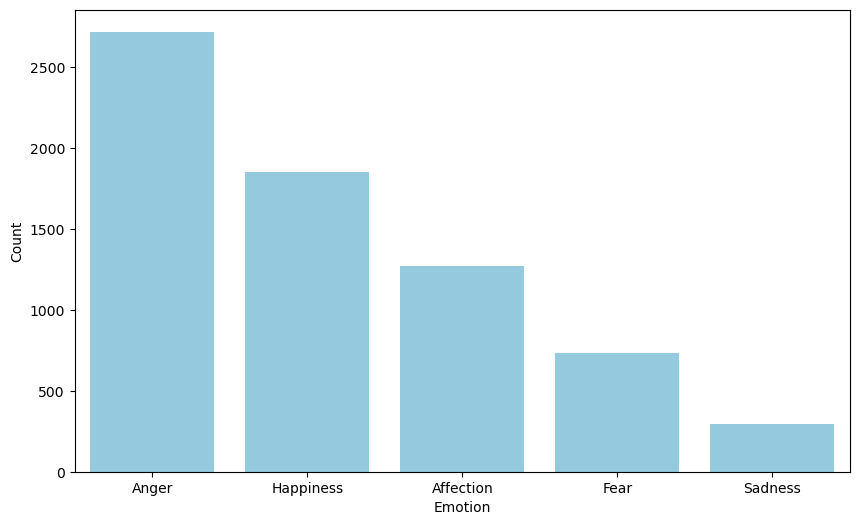

In [53]:
# Count the frequency of each label
label_counts = llama['llama_simple_leia'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, color='skyblue')
#plt.title('Distribution of Emotion Labels, Llama')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [45]:
# Data
emo = ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']
recall = [40.5, 43.7, 24.6, 45.6, 57.0]
precision = [18.8, 49.1, 21.1, 38.5, 64.8]
f1_score = [25.7, 46.2, 22.7, 41.7, 60.7]

# Create DataFrame
table3 = pd.DataFrame({
    'Emotion': emo,
    'Recall (%)': recall,
    'Precision (%)': precision,
    'F1-score (%)': f1_score
})

# Display the DataFrame
table3

,Emotion,Recall (%),Precision (%),F1-score (%)
0,Sadness,40.5,18.8,25.7
1,Happiness,43.7,49.1,46.2
2,Fear,24.6,21.1,22.7
3,Affection,45.6,38.5,41.7
4,Anger,57.0,64.8,60.7


### Mistral

In [47]:
mistral = pd.read_csv('mistral_merged.csv')
mistral = mistral[(mistral['mistral_simple'].str.len() > 136) & (mistral['mistral_simple'].str.len() < 532)]
mistral = mistral[mistral['mistral_simple'].notna()]

In [51]:
# filter non neutral tweets
mistral = mistral[mistral['gpt_sentiment']!='neutral']
mistral['leia_true'] = mistral['text'].progress_apply(lambda x: emotions.get(model(**tokenizer(x, truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 8067/8067 [09:36<00:00, 13.99it/s]


In [52]:
# Apply the function with progress_apply
mistral['mistral_simple_leia'] = mistral['mistral_simple'].astype('str').progress_apply(lambda x: emotions.get(model(**tokenizer(x, 
                                                                                               truncation=True, padding=True, return_tensors="pt")).logits.argmax(dim=1).item()))

Processing sentences: 100%|█████████████████| 8067/8067 [08:05<00:00, 16.60it/s]


In [54]:
# Ensure there are no naming conflicts
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure there are no naming conflicts
true_values = mistral['leia_true'].astype('str')
predicted_values = mistral['mistral_simple_leia'].astype('str')

# Calculate accuracy
accuracy_mistral = accuracy_score(true_values, predicted_values)

# Define class labels
class_labels = ['Sadness', 'Happiness', 'Fear', 'Affection', 'Anger']

# Calculate precision, recall, and F1-score for each class
precision_mistral = precision_score(true_values, predicted_values, average=None, labels=class_labels)
recall_mistral = recall_score(true_values, predicted_values, average=None, labels=class_labels)
f1_mistral = f1_score(true_values, predicted_values, average=None, labels=class_labels)

# Calculate overall precision, recall, and F1-score
precision_macro_mistral = precision_score(true_values, predicted_values, average='macro')
recall_macro_mistral = recall_score(true_values, predicted_values, average='macro')
f1_macro_mistral = f1_score(true_values, predicted_values, average='macro')

# Format the results as requested
formatted_results = f"""
Overall accuracy: {accuracy_mistral * 100:.1f}%
Overall Precision: {precision_macro_mistral * 100:.1f}%
Overall Recall: {recall_macro_mistral * 100:.1f}%
Overall F1 Score: {f1_macro_mistral * 100:.1f}%

Precision (Sadness, Happiness, Fear, Affection, Anger): {[f"{p * 100:.1f}%" for p in precision_mistral]}
Recall (Sadness, Happiness, Fear, Affection, Anger): {[f"{r * 100:.1f}%" for r in recall_mistral]}
F1 Score (Sadness, Happiness, Fear, Affection, Anger): {[f"{f * 100:.1f}%" for f in f1_mistral]}
"""

print(formatted_results)



Overall accuracy: 48.6%
Overall Precision: 44.4%
Overall Recall: 46.6%
Overall F1 Score: 44.4%

Precision (Sadness, Happiness, Fear, Affection, Anger): ['37.2%', '46.1%', '22.9%', '44.6%', '71.5%']
Recall (Sadness, Happiness, Fear, Affection, Anger): ['49.0%', '60.7%', '33.0%', '44.6%', '45.5%']
F1 Score (Sadness, Happiness, Fear, Affection, Anger): ['42.3%', '52.4%', '27.0%', '44.6%', '55.6%']



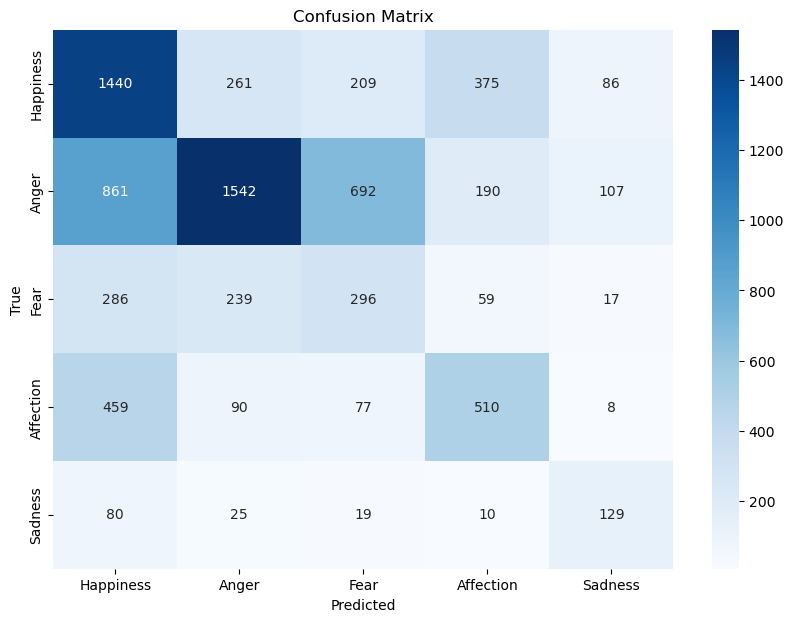

In [57]:
cm = confusion_matrix(mistral['leia_true'], mistral['mistral_simple_leia'], labels=mistral['leia_true'].unique())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mistral['leia_true'].unique(), yticklabels=mistral['leia_true'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

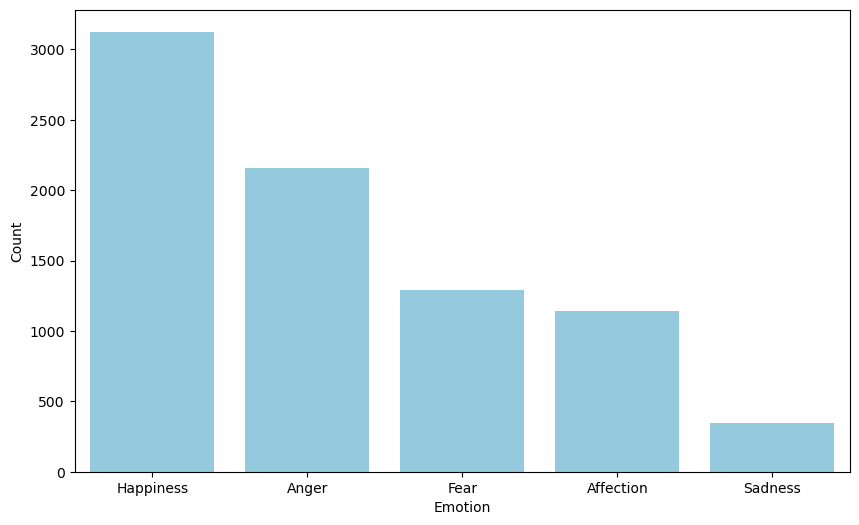

In [59]:
# Count the frequency of each label
label_counts = mistral['mistral_simple_leia'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, color='skyblue')
#plt.title('Distribution of Emotion Labels, Mistral')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()